In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!apt-get update
!apt-get install -y colmap
!pip install opencv-python open3d

Mounted at /content/drive
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,769 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/multiverse am

In [ ]:
import os

# Define fresh paths for v3
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v3"
VIDEO_DIR = f"{BASE_DIR}/video"
FRAMES_DIR = f"{BASE_DIR}/frames"
PC_DIR = f"{BASE_DIR}/point_cloud"

# Create directories
for d in [VIDEO_DIR, FRAMES_DIR, PC_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"✅ Clean file system created at: {BASE_DIR}")

✅ Clean file system created at: /content/drive/MyDrive/Hackathon_MVP_v3


In [7]:
import cv2
import os

VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v3/video/IMG_1314.MOV"
FRAMES_DIR = "/content/drive/MyDrive/Hackathon_MVP_v3/frames"

TARGET_FPS = 10
TARGET_WIDTH = 1280
TARGET_HEIGHT = 720

if not os.path.exists(VIDEO_PATH):
    print(f"❌ ERROR: Cannot find video. Check that it is inside {VIDEO_PATH}")
else:
    cap = cv2.VideoCapture(VIDEO_PATH)
    os.makedirs(FRAMES_DIR, exist_ok=True)

    native_fps = cap.get(cv2.CAP_PROP_FPS)
    if native_fps == 0:
        native_fps = 30  # fallback

    frame_stride = int(round(native_fps / TARGET_FPS))
    if frame_stride < 1:
        frame_stride = 1

    print(f"Video found.")
    print(f"Native FPS: {native_fps}")
    print(f"Extracting at: {TARGET_FPS} FPS (stride = {frame_stride})")
    print(f"Resolution: {TARGET_WIDTH} x {TARGET_HEIGHT}")

    count = 0
    saved = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_stride == 0:
            frame = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT))
            cv2.imwrite(
                os.path.join(FRAMES_DIR, f"frame_{saved:05d}.jpg"),
                frame
            )
            saved += 1

        count += 1

    cap.release()
    print(f"✅ Extracted {saved} frames successfully.")

Video found.
Native FPS: 30.0
Extracting at: 10 FPS (stride = 3)
Resolution: 1280 x 720
✅ Extracted 88 frames successfully.


In [8]:
import os
import subprocess

# Block the GUI crash
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# Paths for v3
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v3"
IMAGE_DIR = f"{BASE_DIR}/frames"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model"
DB_PATH = f"{WORKSPACE_DIR}/database.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/model_sparse.ply"

# Create workspace
os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)

# Helper to run shell commands
def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in proc.stdout:
        print(line, end="")
    proc.wait()
    if proc.returncode != 0:
        raise subprocess.CalledProcessError(proc.returncode, cmd)

print("STARTING COLMAP (CPU MODE)")

# 1. Extract Features (CPU only)
run_cmd([
    "colmap", "feature_extractor",
    "--database_path", DB_PATH,
    "--image_path", IMAGE_DIR,
    "--ImageReader.single_camera", "1",
    "--SiftExtraction.use_gpu", "0"
])

# 2. Match Features (CPU only)
run_cmd([
    "colmap", "sequential_matcher",
    "--database_path", DB_PATH,
    "--SequentialMatching.overlap", "10",
    "--SiftMatching.use_gpu", "0"
])

# 3. Map / Sparse Reconstruction (CPU only)
run_cmd([
    "colmap", "mapper",
    "--database_path", DB_PATH,
    "--image_path", IMAGE_DIR,
    "--output_path", WORKSPACE_DIR
])

# 4. Export PLY point cloud
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd([
        "colmap", "model_converter",
        "--input_path", f"{WORKSPACE_DIR}/0",
        "--output_path", OUT_PLY,
        "--output_type", "PLY"
    ])
    print(f"\n✅ SUCCESS! Model saved to: {OUT_PLY}")
else:
    print("\n❌ ERROR: Mapping failed to produce a model.")

Streaming output truncated to the last 5000 lines.
   Iterations : 4
         Time : 0.0194099 [s]
 Initial cost : 0.257272 [px]
   Final cost : 0.25326 [px]
  Termination : Convergence

  => Continued observations: 1857
  => Added observations: 364

Bundle adjustment report
------------------------
    Residuals : 40756
   Parameters : 7154
   Iterations : 6
         Time : 0.310584 [s]
 Initial cost : 0.222652 [px]
   Final cost : 0.217781 [px]
  Termination : Convergence

  => Merged observations: 15
  => Completed observations: 101
  => Filtered observations: 22
  => Changed observations: 0.006457

Bundle adjustment report
------------------------
    Residuals : 40910
   Parameters : 7142
   Iterations : 2
         Time : 0.111194 [s]
 Initial cost : 0.249137 [px]
   Final cost : 0.244705 [px]
  Termination : Convergence

  => Merged observations: 10
  => Completed observations: 10
  => Filtered observations: 0
  => Changed observations: 0.000932

Registering image #1 (13)

  => I

Loaded 40724 points


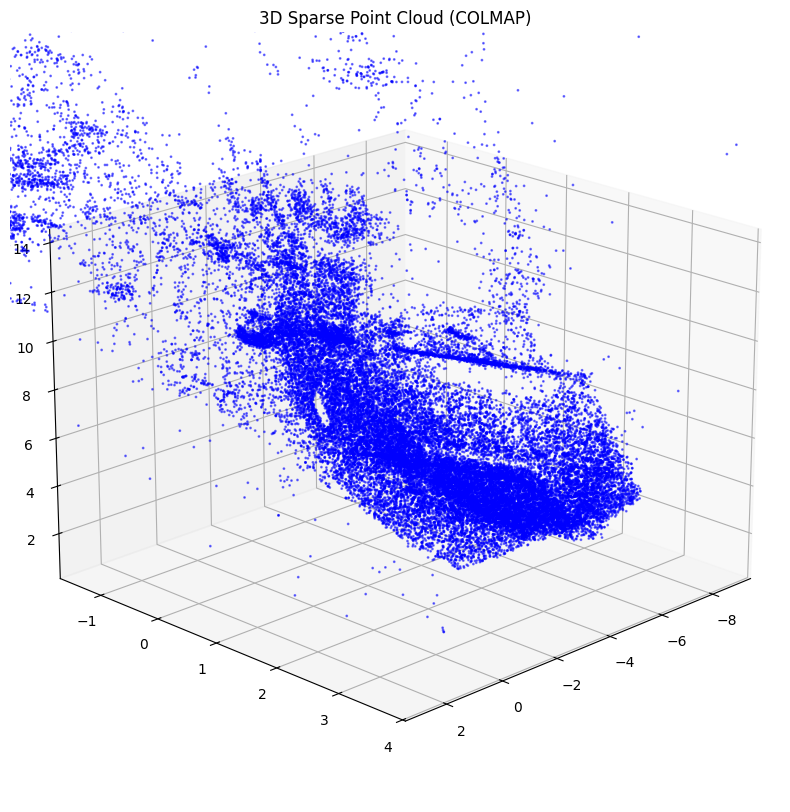

✅ Model contains 40724 points.


In [42]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Path to the v3 model you just created
ply_path = "/content/drive/MyDrive/Hackathon_MVP_v3/point_cloud/model_sparse.ply"

if not os.path.exists(ply_path):
    print(f"❌ ERROR: Could not find the file at {ply_path}")
else:
    # Load the point cloud
    pcd = o3d.io.read_point_cloud(ply_path)

    # Extract XYZ points
    points = np.asarray(pcd.points)
    print(f"Loaded {len(points)} points")

    # --- Setup plot ---
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot ALL points
    ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        s=1,
        c='blue',
        alpha=0.5
    )

    ax.set_title("3D Sparse Point Cloud (COLMAP)")
    ax.view_init(elev=20, azim=45)

    # --- Zoom logic ---
    center = points.mean(axis=0)
    zoom = 0.5  # smaller = tighter zoom

    ranges = points.max(axis=0) - points.min(axis=0)
    half_range = ranges * zoom / 2

    ax.set_xlim(center[0] - half_range[0], center[0] + half_range[0])
    ax.set_ylim(center[1] - half_range[1], center[1] + half_range[1])
    ax.set_zlim(center[2] - half_range[2], center[2] + half_range[2])

    plt.show()

    print(f"✅ Model contains {len(points)} points.")

In [14]:
import cv2
import os

VIDEO_PATH = "/content/drive/MyDrive/Hackathon_MVP_v3/video/IMG_1315.MOV"
FRAMES_DIR = "/content/drive/MyDrive/Hackathon_MVP_v3/frames_1315"

TARGET_FPS = 10
TARGET_WIDTH = 1280
TARGET_HEIGHT = 720

if not os.path.exists(VIDEO_PATH):
    print(f"❌ ERROR: Cannot find video. Check that it is inside {VIDEO_PATH}")
else:
    cap = cv2.VideoCapture(VIDEO_PATH)
    os.makedirs(FRAMES_DIR, exist_ok=True)

    native_fps = cap.get(cv2.CAP_PROP_FPS)
    if native_fps == 0:
        native_fps = 30  # fallback

    frame_stride = int(round(native_fps / TARGET_FPS))
    if frame_stride < 1:
        frame_stride = 1

    print("Video found.")
    print(f"Native FPS: {native_fps}")
    print(f"Extracting at: {TARGET_FPS} FPS (stride = {frame_stride})")
    print(f"Resolution: {TARGET_WIDTH} x {TARGET_HEIGHT}")

    count = 0
    saved = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_stride == 0:
            frame = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT))
            cv2.imwrite(
                os.path.join(FRAMES_DIR, f"frame_{saved:05d}.jpg"),
                frame
            )
            saved += 1

        count += 1

    cap.release()
    print(f"✅ Extracted {saved} frames successfully from IMG_1315.MOV.")

Video found.
Native FPS: 30.0
Extracting at: 10 FPS (stride = 3)
Resolution: 1280 x 720
✅ Extracted 79 frames successfully from IMG_1315.MOV.


In [15]:
import os
import subprocess

# Block the GUI crash
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# Paths for IMG_1315
BASE_DIR = "/content/drive/MyDrive/Hackathon_MVP_v3"
IMAGE_DIR = f"{BASE_DIR}/frames_1315"
WORKSPACE_DIR = f"{BASE_DIR}/point_cloud/model_1315"
DB_PATH = f"{WORKSPACE_DIR}/database.db"
OUT_PLY = f"{BASE_DIR}/point_cloud/model_sparse_1315.ply"

# Create workspace
os.makedirs(WORKSPACE_DIR, exist_ok=True)
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)

# Helper to run shell commands
def run_cmd(cmd):
    print(f"\n--- Running: {cmd[1]} ---")
    proc = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True
    )
    for line in proc.stdout:
        print(line, end="")
    proc.wait()
    if proc.returncode != 0:
        raise subprocess.CalledProcessError(proc.returncode, cmd)

print("STARTING COLMAP (CPU MODE) — IMG_1315")

# 1. Extract Features
run_cmd([
    "colmap", "feature_extractor",
    "--database_path", DB_PATH,
    "--image_path", IMAGE_DIR,
    "--ImageReader.single_camera", "1",
    "--SiftExtraction.use_gpu", "0"
])

# 2. Match Features (sequential — good for video)
run_cmd([
    "colmap", "sequential_matcher",
    "--database_path", DB_PATH,
    "--SequentialMatching.overlap", "10",
    "--SiftMatching.use_gpu", "0"
])

# 3. Sparse reconstruction
run_cmd([
    "colmap", "mapper",
    "--database_path", DB_PATH,
    "--image_path", IMAGE_DIR,
    "--output_path", WORKSPACE_DIR
])

# 4. Export PLY
if os.path.exists(f"{WORKSPACE_DIR}/0"):
    run_cmd([
        "colmap", "model_converter",
        "--input_path", f"{WORKSPACE_DIR}/0",
        "--output_path", OUT_PLY,
        "--output_type", "PLY"
    ])
    print(f"\n✅ SUCCESS! Model saved to: {OUT_PLY}")
else:
    print("\n❌ ERROR: Mapping failed to produce a model.")

Streaming output truncated to the last 5000 lines.
  => Completed observations: 1
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.429006e+02    0.00e+00    8.68e+02   0.00e+00   0.00e+00  1.00e+04        0    6.08e-02    1.08e-01
   1  6.424358e+02    4.65e-01    8.64e+00   2.67e+00   9.99e-01  3.00e+04        1    1.57e-01    2.66e-01
   2  6.424271e+02    8.66e-03    5.68e+00   9.73e-01   1.00e+00  9.00e+04        1    1.25e-01    3.91e-01
   3  6.424252e+02    1.94e-03    1.75e+01   1.69e+00   1.01e+00  2.70e+05        1    1.32e-01    5.23e-01
   4  6.424208e+02    4.38e-03    1.21e+02   4.00e+00   9.85e-01  8.10e+05        1    1.03e-01    6.26e-01
   5  6.424159e+02    4.85e-03    8.46e+02   8.23e+00   4.73e-01  8.10e+05        1    9.90e-02    7.25e-01
   6  6.424060e+02    9.97e-03    7.04e+02   6.77e+00   7.21e-01  8.87e

Loaded 33238 points


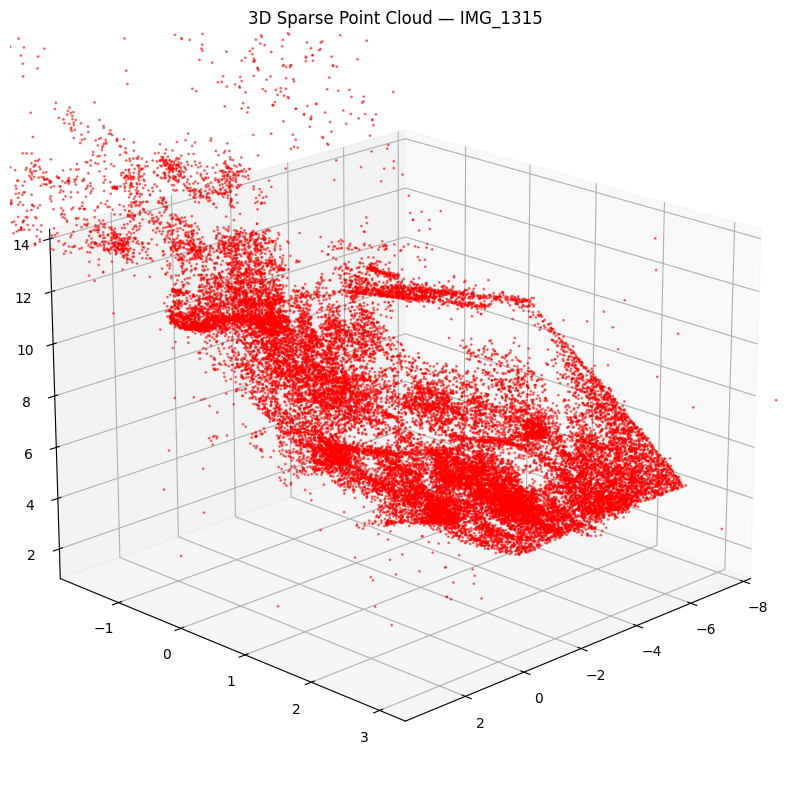

✅ Visualization complete.


In [43]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# ✅ Correct path based on your COLMAP export
ply_path = "/content/drive/MyDrive/Hackathon_MVP_v3/point_cloud/model_sparse_1315.ply"

if not os.path.exists(ply_path):
    print(f"❌ ERROR: Could not find the file at {ply_path}")
else:
    # Load point cloud
    pcd = o3d.io.read_point_cloud(ply_path)

    # Extract XYZ points
    points = np.asarray(pcd.points)
    print(f"Loaded {len(points)} points")

    # --- Setup Matplotlib 3D plot ---
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot ALL points
    ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        s=1,
        c='red',   # color for IMG_1315
        alpha=0.5
    )

    ax.set_title("3D Sparse Point Cloud — IMG_1315")
    ax.view_init(elev=20, azim=45)

    # ---- Zoom logic ----
    center = points.mean(axis=0)
    zoom = 0.5  # smaller = tighter zoom

    ranges = points.max(axis=0) - points.min(axis=0)
    half_range = ranges * zoom / 2

    ax.set_xlim(center[0] - half_range[0], center[0] + half_range[0])
    ax.set_ylim(center[1] - half_range[1], center[1] + half_range[1])
    ax.set_zlim(center[2] - half_range[2], center[2] + half_range[2])

    plt.show()

    print("✅ Visualization complete.")

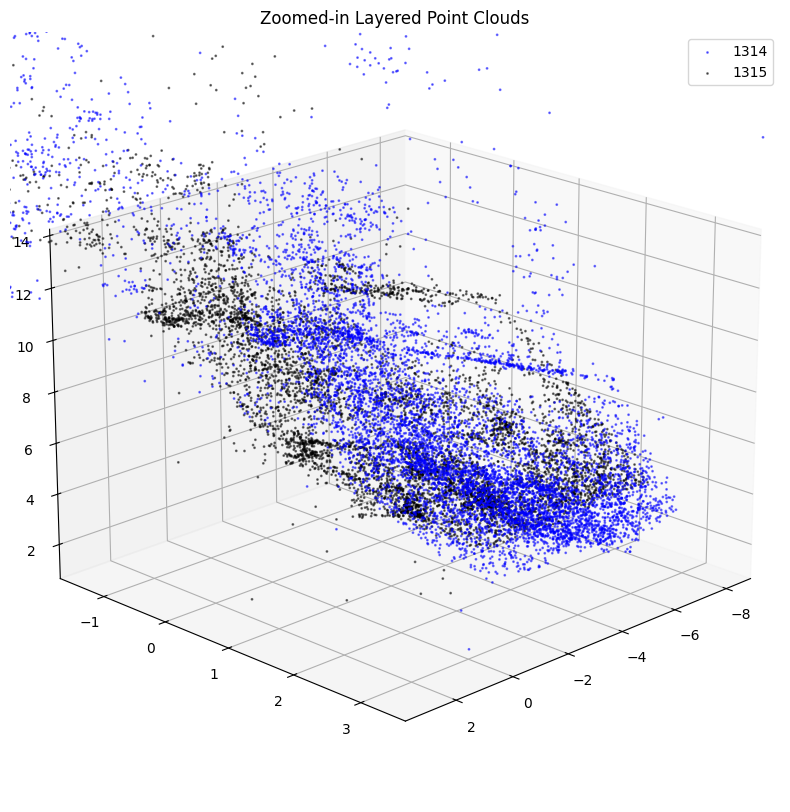

In [47]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

PLY_1 = "/content/drive/MyDrive/Hackathon_MVP_v3/point_cloud/model_sparse.ply"
PLY_2 = "/content/drive/MyDrive/Hackathon_MVP_v3/point_cloud/model_sparse_1315.ply"

pcd1 = o3d.io.read_point_cloud(PLY_1)
pcd2 = o3d.io.read_point_cloud(PLY_2)

pts1 = np.asarray(pcd1.points)[::5]
pts2 = np.asarray(pcd2.points)[::5]

# Combine for shared bounds
all_pts = np.vstack([pts1, pts2])

# Compute center
center = all_pts.mean(axis=0)

# Zoom factor: smaller = more zoom
ZOOM = 0.5   # try 0.2–0.4

ranges = all_pts.max(axis=0) - all_pts.min(axis=0)
half = ranges * ZOOM / 2

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts1[:,0], pts1[:,1], pts1[:,2],
           s=1, alpha=0.5, c='blue', label="1314")

ax.scatter(pts2[:,0], pts2[:,1], pts2[:,2],
           s=1, alpha=0.5, c='black', label="1315")

ax.set_xlim(center[0] - half[0], center[0] + half[0])
ax.set_ylim(center[1] - half[1], center[1] + half[1])
ax.set_zlim(center[2] - half[2], center[2] + half[2])

ax.view_init(elev=20, azim=45)
ax.set_title("Zoomed-in Layered Point Clouds")
ax.legend()

plt.show()